## MyConnectome analyses

In this notebook we will examine various analyses of the resting fMRI data from the MyConnectome study.  

### Resting state functional connectivity

The fmri data were first projected onto the surface and then averaged within a set of 616 cortical regions identified using surface-based parcellation, as well as 14 subcortical regions.  The mean fMRI signal was then extracted from each of those regions for each time point.  See Laumann et al. (2015, *Neuron*) for more details on data processing.  

First let's set everythign up and load the data (downloading it if it doesn't already exist).

In [93]:
import os
import numpy
import pandas
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,8)
%matplotlib inline
import scipy.stats,scipy.spatial
from collections import Counter
import scipy.cluster.hierarchy
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge,RidgeCV,LinearRegression
from sklearn.metrics import explained_variance_score,mean_absolute_error
import nilearn.plotting
import seaborn 

import cairocffi # needed for igraph plotting on Mac
import igraph

from get_balanced_folds import BalancedKFold

# if data don't exist then download them
if not os.path.exists('data'):
    # download the data
    import requests,tarfile
    print('no data directory, downloading the data...')
    url = "http://web.stanford.edu/group/poldracklab/myconnectome-example/data.tgz"
    filename = url.split("/")[-1]
    with open(filename, "wb") as f:
        r = requests.get(url)
        f.write(r.content)
    print('unpacking data.tgz')
    file = tarfile.open('data.tgz', 'r:gz')
    file.extractall()
    file.close()
    os.remove('data.tgz')

# set this to the location of the datafiles on your system - if automatically downloaded then it will be "./data"
datadir='data'
assert os.path.exists(datadir)

# load the correlation data. This matrix contains
# the upper triangle of the correlation matrix between each of the 630
# regions, across each of the 84 good sessions
corrdata=numpy.load(os.path.join(datadir,'rsfmri/corrdata.npy'))
meancorr=numpy.mean(corrdata,0)

# load information about the regions (which we call "parcels")
parceldata=pandas.read_csv(os.path.join(datadir,'parcel_data.txt'),
                          header=None,sep='\t')
parceldata.replace(to_replace='na', value='Subcortical', inplace=True)
parceldata.replace(to_replace='Zero', value='Unassigned', inplace=True)
parceldata.columns=['num','hemis','X','Y','Z','lobe','sublobe',
                    'power','yeo7','yeo17']


# The data are stored as upper triangle, but we need to put them back into
# a matrix for some operations, so we create a utility function
# to do this
def mtx_from_utr(utr,complete=True):
    """
    create full weight matrix from upper triangle, taking mean across first axis
    complete: should bottom triangle be completed as well?
    """
    mtx=numpy.zeros((630,630))
    if len(utr.shape)>1:
        mtx[numpy.triu_indices_from(mtx,1)]=utr.mean(axis=0)
    else:
        mtx[numpy.triu_indices_from(mtx,1)]=utr
       
    if complete:
        mtx=mtx+mtx.T
    return(mtx)



Using the regional timeseries, functional connectivity was estimated between each of these pairs of regions using Pearson correlation, giving a total of 198135 connections.   Let's have a look at the correlation matrix of the 630 regions.  These are not sorted systematically within hemisphere, but the first 308 are in the left hemisphere and the second 308 are in the right hemisphere, with the remainder in the subcortex.  The white lines in the plot separate the hemisphere and subcortical regions.

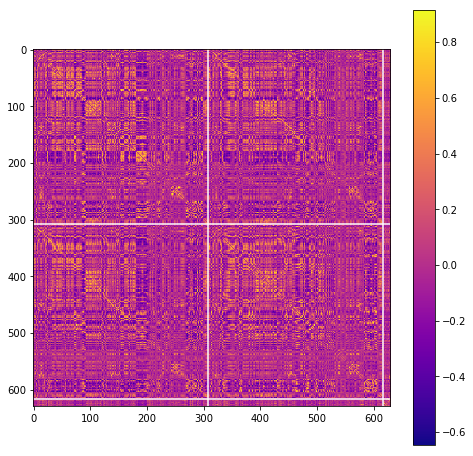

In [41]:
#  make mean correlation matrix
meancorrmtx=mtx_from_utr(corrdata)

# plot the mean correlation matrix
plt.figure(figsize=(8,8))
plt.imshow(meancorrmtx,cmap='plasma')
plt.plot([0,629],[616/2,616/2],color='white')
plt.plot([0,629],[616,616],color='white')
plt.plot([616/2,616/2],[0,629],color='white')
plt.plot([616,616],[0,629],color='white')
plt.colorbar()

There is clearly a wide range of correlations, with a good deal of structure, both within and between hemispheres. In the last decade it has become common to characterize this structure in terms of a set of "resting state networks", which are usually obtained by some sort of unsupervised learning method.  

We could start by simply clustering the regions using hierarchical clustering.

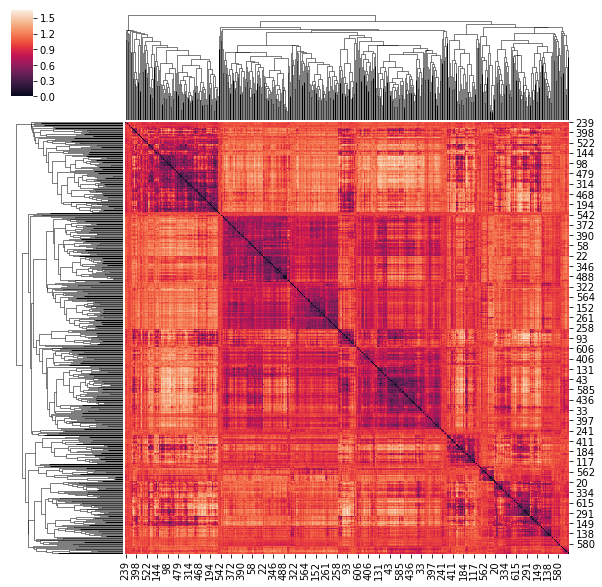

In [95]:
plt.figure(figsize=(10,10))

distmtx = 1 - meancorrmtx  # distance matrix
distmtx[numpy.diag_indices_from(distmtx)]=0
linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(distmtx), method='average')
seaborn.clustermap(distmtx, row_linkage=linkage, col_linkage=linkage)


It's more common in the fMRI literature to identify resting state networks using a network clustering (or "community detection") algorithm, which identifies sets of nodes that are more strongly connected with one another than they are with other sets of nodes.  This requires that we first represent the network as a graph.  Most of these techniques require that we represent it as a binary undirected graph, though this requires the selection of an arbitrary threshold.  In the Laumann et al. paper we used a consensus clustering technique that identifies communities that are consistent across multiple thresholds, but for simplicitly here we will just use a single threshold.

In [96]:
# what proportion of edges do we want? this is arbitrary.
# use this to find the cutoff for this proportion
density=0.05 
cutoff=scipy.stats.scoreatpercentile(meancorr,100-density*100)

# create binarized adjacency matrix
adjmtx=mtx_from_utr(corrdata)
adjmtx[adjmtx<cutoff]=0
adjmtx[adjmtx>0]=1

# use igraph to generate an undirected graph representation
# of our network
G = igraph.Graph.Adjacency(adjmtx.tolist(),mode='UNDIRECTED')
print('Original graph summary:')
print(G.summary())

# for network analyses we generally only look at the 
# largest connected component of the graph, known as the giant component

# save original community membership to graph variable
parcel_networks=parceldata.iloc[:,7].values
for v in G.vs:
    v['powernetwork']=parcel_networks[v.index]
    
# find giant component
vc = G.components() ##Get VertexClustering object
G_gc=vc.giant()
print('Giant component summary:')
print(G_gc.summary())

Original graph summary:
IGRAPH U--- 630 9907 -- 
Giant component summary:
IGRAPH U--- 566 9889 -- 
+ attr: powernetwork (v)


Given this graph representation, one thing we can do is to visualize the graph by embedding it in a two-dimensional space. Here we use a "force-directed" layout generated using the Fruchterman-Reingold algorithm (https://github.com/gephi/gephi/wiki/Fruchterman-Reingold), in which nodes repel each other and edges between nodes result in attraction.

In [98]:
visual_style = {"vertex_size":8}
igraph.plot(G_gc, layout="fr",**visual_style)

Now let's perform community detection on this graph.  There are a number of methods for doing this; in Laumann et al. we used a method called infomap (code available at https://github.com/mapequation/infomap).  Here we will use an implementation of infomap available within the igraph library.

In [103]:
# use the infomap algorithm to perform community detection
community=G_gc.community_infomap(trials=50)

# save infomap community membership to each node
for v in G_gc.vs:
    v['infomap']=community.membership[v.index]

print(numpy.unique(community.membership))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Now let's show the graph using the community assignments to color code the nodes.

In [104]:
pal = igraph.drawing.colors.ClusterColoringPalette(len(community))
G_gc.vs['color'] = pal.get_many(community.membership)
visual_style = {"vertex_size":8}

igraph.plot(G_gc, layout="fr",**visual_style)


In the Laumann et al. paper, the infomap communities identified using consensus clustering were named according to a scheme develped by Power et al.  Here is the adjacency matrix sorted by those communities, along with their names.

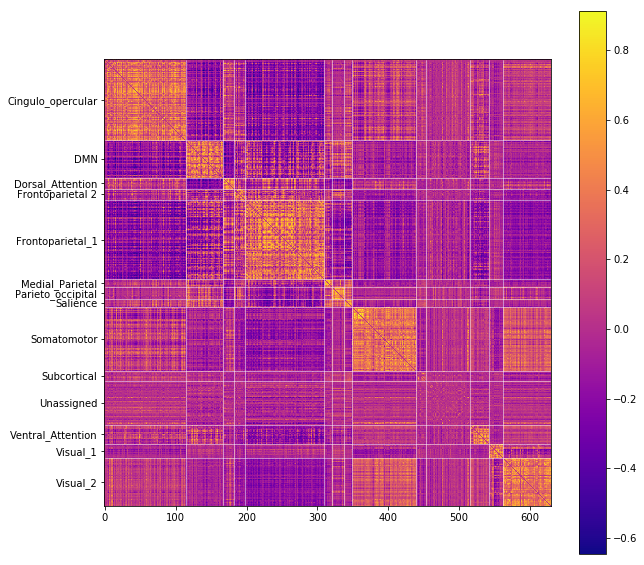

In [125]:
def reorder_corrs(corrmtx,parceldata,labels='power'):
    """
    reorder correlation matrix according to network labels
    """
    idx=numpy.argsort(parceldata[labels])
    tmp=corrmtx[:,idx]
    return(tmp[idx,:],parceldata.iloc[idx,:])

def plot_reordered_corrs(corrmtx,parceldata,labels='power'):
    """
    plot correlation matrix after reordering
    """

    corr_reord,parceldata_reord=reorder_corrs(corrmtx,parceldata,labels)
    plt.figure(figsize=(10,10))
    plt.imshow(corr_reord,cmap='plasma')
    # find breakpoints and plot lines
    breaks=numpy.array([int(not i) for i in parceldata_reord[labels].values[:-1]==parceldata_reord[labels].values[1:]])
    breaklocs=numpy.where(breaks)[0]
    for b in breaklocs:
        plt.plot([0,corrmtx.shape[0]-1],[b,b],color='w',linewidth=0.5)
        plt.plot([b,b],[0,corrmtx.shape[0]-1],color='w',linewidth=0.5)
    # find label locations
    # add a zero to help find label locations 
    breaklocs=numpy.hstack((breaklocs,[len(breaks)]))
    breaklocs2=numpy.hstack(([0],breaklocs))
    label_locs=numpy.mean(numpy.vstack((breaklocs,breaklocs2[:-1])),0)
    networks=parceldata_reord['power'].values[breaklocs]
    ax=plt.gca()
    ax.set_yticks(label_locs)
    ax.set_yticklabels(networks)
    plt.colorbar()

plot_reordered_corrs(meancorrmtx,parceldata)

We can also visualize the networks projected into the 3-d space of the brain, using nilearn's plot_connectome() function. This is somewhat slow...

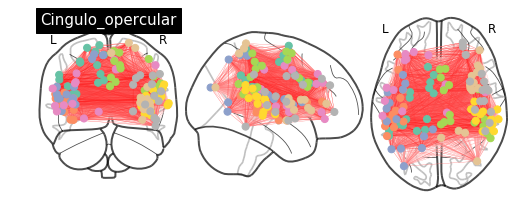

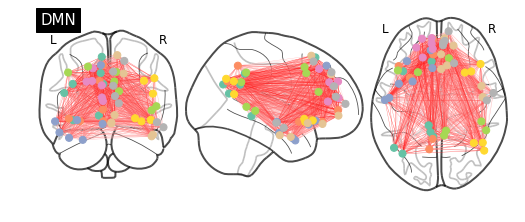

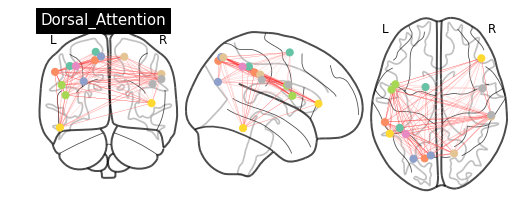

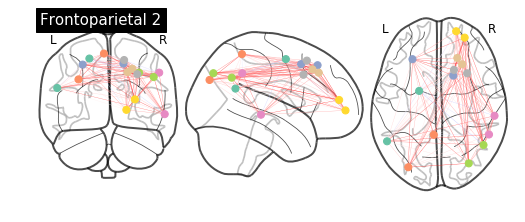

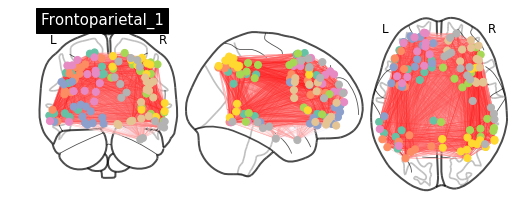

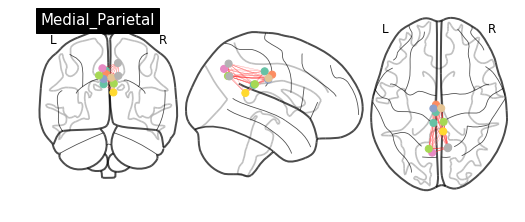

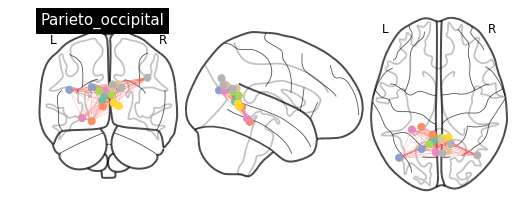

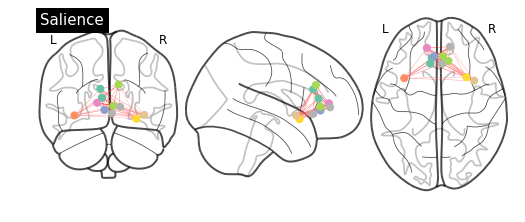

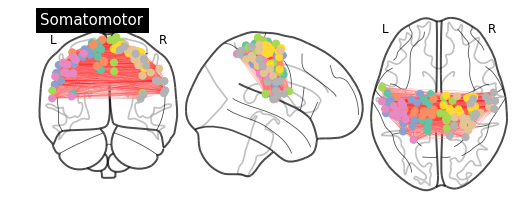

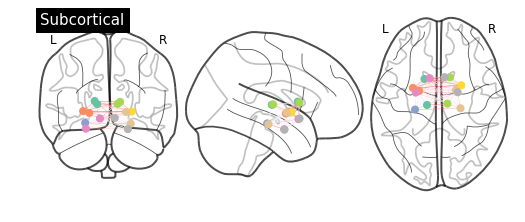

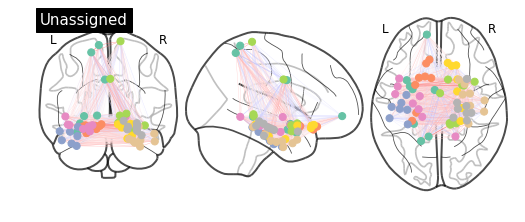

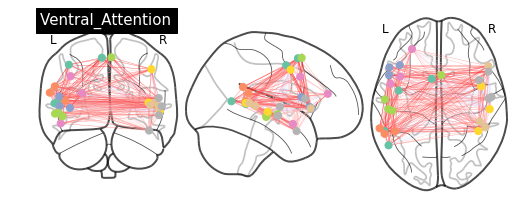

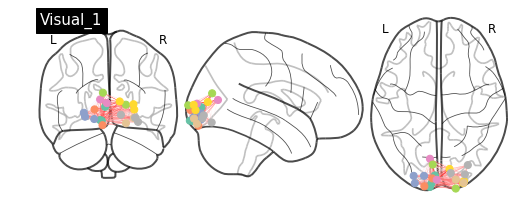

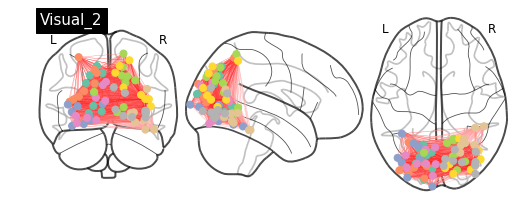

In [126]:
for network in numpy.unique(parceldata.iloc[:,7]):
    adjmtx=meancorrmtx
    # create an adjacency matrix containing only parcels from a specific network
    network_matches=parceldata.iloc[:,7].values==network
    adjmtx=adjmtx[network_matches,:]
    adjmtx=adjmtx[:,network_matches]
    nilearn.plotting.plot_connectome(adjmtx, parceldata.iloc[network_matches,2:5],
                                title=network,
                                edge_kwargs={'linewidth':0.3})

### Predicting affect from connectivity

After each resting scan, the subject completed a Positive and Negative Affect Scale (PANAS) which provides measures of positive and negative mood and fatigue.  In this example we will attempt to predict mood and fatigue measures from functional connectivity estimated from resting fMRI. 

Now let's create a function that will predict panas scores from connectivity matrices.  Here we use a special crossvalidation operator that implements balanced cross validation for continuous variables, which basically ensures that every crossvalidation fold has a roughly similar distribution on the Y variable.  If we don't do this, then we could end up with biased estimates of the correlation between predicted and true values (see https://github.com/poldrack/regressioncv/blob/master/regressioncv.ipynb,  http://www.russpoldrack.org/2012/12/the-perils-of-leave-one-out.html and http://not2hastie.tumblr.com/).  We will compute two measures of prediction accuracy.  The first is variance explained between predicted and actual ratings (which provides an interpretable measure of predctive ability and is commonly used in the imaging literature):

$$
explained\_variance(y,\hat{y}) = 1 - \frac{Var(y - \hat{y})}{Var(y)}
$$

This is often referred to as "R-squared" though note that it's not computed by squaring the correlation coefficient, and that it can in fact be negative (when the predictions are so bad that the residuals are greater than the variability in the data).  As shown in the notebook linked above, this is actually a pretty bad measure for quantifying predictive accuracy, but it's commonly used so we include it here.

The second is mean absolute error (which may be more relevant if our goal is prediction of precise values):

$$
MAE(y,\hat{y}) = \sum{|y-\hat{y}|}
$$

Here we use a ridge penalty to regularize the model since the number of features is much larger than the number of observations.  We use the RidgeCV classifier which performs an inner cross-validation to select the ridge penalty.


In [39]:
# load the behavioral data, which includes the PANAS scores
behavdata=pandas.read_csv(os.path.join(datadir,'trackingdata_goodscans.txt'),
                         header=0,sep='\t',na_values='.')
# reduce to the three variables that we will work with
behavdata=behavdata[['panas:positive','panas:negative','panas:fatigue']]

#

In [40]:
# define some necessary functions

def rotate_timeseries(Y):
    """
    randomly shuffle a timeseries by rotation
    to preserve autocorrelation structure
    i.e. "poor man's block randomization"
    """
    d=numpy.random.randint(Y.shape[0])
    newY=numpy.zeros(Y.shape)
    newY[0:Y.shape[0]-d]=Y[d:Y.shape[0]]
    newY[(Y.shape[0]-d):Y.shape[0]]=Y[0:d]
    return(newY)
    

def panas_predict(Yvar,behavdata,corrdata,
                  shuffle=False,
                  n_splits=20,
                  clf=RidgeCV(),
                  cv=BalancedKFold(nfolds=4,pthresh=0.99),
                  scaler=StandardScaler(),
                  return_weights=False,
                  print_results=True,
                  scale_Y=True,
                  weight_pval=None):
    """
    run prediction analysis on panas data
    Yvar: name of Y variable
    shuffle: if  True, then the Y values will be randomly shuffled on each round
    scaler: set to None to turn off scaling
    scale_Y: scale the Y variable so that MAE is in z-score units
    """
    # remove session with missing values for Y variable
    goodY=numpy.isfinite(behavdata[Yvar].values)
    Y=behavdata[Yvar].values[goodY]
    if scale_Y:
        Y=scaler.fit_transform(Y[:,numpy.newaxis])[:,0]
        unitstring=' (z-score units)'
    else:
        unitstring=''
    X=corrdata[goodY,:]
    X=scaler.fit_transform(X)
    # create output variables
    explained_var=numpy.zeros(n_splits) 
    meanabserr=numpy.zeros(n_splits) 
    mean_weights=numpy.zeros((n_splits,corrdata.shape[1]))
    
    # loop through multiple random splits
    # to ensure that any results are not due to particular split
    for i in range(n_splits):
        weights=numpy.zeros((cv.nfolds,corrdata.shape[1])) # save weights for this run
        if shuffle:
            # since the timeseries may be autocorrelated, using a rotation approach that should
            # largely retain the same autocorrelation structure.
            Y=rotate_timeseries(Y)
        pred=numpy.zeros(X.shape[0]) # to store predictions
        cvctr=0
        for train_index, test_index in cv.split(X,Y):            
            X_train, X_test = X[train_index,:], X[test_index,:]
            y_train, y_test = Y[train_index], Y[test_index]
            if scaler is not None:
                # learn the scaler from training data
                X_train=scaler.fit_transform(X_train)
                # apply scaler to test data
                X_test=scaler.transform(X_test)

            clf.fit(X_train,y_train)
            if hasattr(clf,'coef_'):
                weights[cvctr,:]=clf.coef_
                cvctr+=1
            pred[test_index]=clf.predict(X_test)
            
        mean_weights[i,:]=weights.mean(axis=0)
        explained_var[i]=explained_variance_score(Y,pred)
        meanabserr[i]=mean_absolute_error(Y,pred)
    
    print('Prediction analysis for',Yvar)
    if shuffle:
        print('with shuffled Y values: ')
    print('Mean explained variance (+/- SD):',explained_var.mean(),explained_var.std())
    print('Mean MAE%s (+/- SD):'%unitstring,meanabserr.mean(),meanabserr.std())
    print('')
    if shuffle:
        # return 95 %ile

        print('Cutoffs for null distribution')
        if n_splits<1000:
            print('WARNING: %d is too few iterations for stable tail estimates'%n_splits)
        print('explained variance (95%):',scipy.stats.scoreatpercentile(explained_var,95))
        print('MAE (5%):',scipy.stats.scoreatpercentile(meanabserr,5))
    if return_weights:
        return(explained_var,meanabserr,mean_weights)
    else:
        return(explained_var,meanabserr)


In [29]:
# run it once with positive affect data
_,_=panas_predict('panas:positive',behavdata,corrdata)


Prediction analysis for panas:positive
Mean explained variance (+/- SD): 0.145982430085 0.0475209058173
Mean MAE (z-score units) (+/- SD): 0.757076654225 0.0212931914472



We would often like to know whether our predictive performance is better than one would expect under the null hypothesis of no relationship.  This is generally done using randomization to simulate the null, which requires assumption of exchangeability, i.e. that the joint distriubtion of the resampled data is identical to the original data. A common source of violation is autocorrelation. To check for this, let's look at the autocorrelation of each of the timeseries.

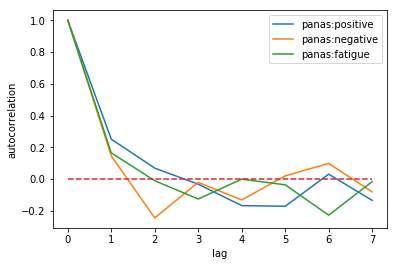

In [4]:
acorr={}
for Yvar in behavdata.columns:
    #goodY=numpy.isfinite(behavdata[Yvar].values)
    #Y=behavdata[Yvar].values[goodY]

    acorr[Yvar]=[behavdata[Yvar].autocorr(i) for i in numpy.arange(0,8)]
    
    plt.plot(numpy.arange(0,8),acorr[Yvar],label=Yvar)
plt.plot(numpy.arange(0,8),numpy.zeros(8),linestyle='dashed')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.legend()

From this it appears that there is some small degree of autocorrelation, meaning that we can't use a simple randomization approach.  For this reason, we use a block rotation approach which should largely retain the autocorrelation structure.  Let's make sure:

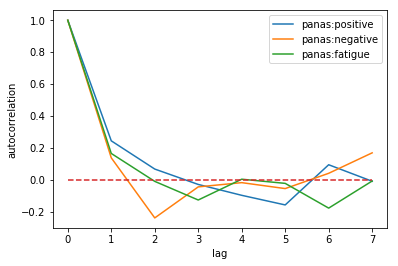

In [5]:
acorr={}
for i,Yvar in enumerate(behavdata.columns):
    #goodY=numpy.isfinite(behavdata[Yvar].values)
    #Y=behavdata[Yvar].values[goodY]
    rotated=behavdata.iloc[:,i]
    rotated=pandas.Series(rotate_timeseries(rotated))
    acorr[Yvar]=[rotated.autocorr(i) for i in numpy.arange(0,8)]
    
    plt.plot(numpy.arange(0,8),acorr[Yvar],label=Yvar)
plt.plot(numpy.arange(0,8),numpy.zeros(8),linestyle='dashed')
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.legend()

In [6]:
# run with shuffled data
# in reality we would want to rerun the permuted version many more times
# to compute a realistic null distribution

_,_=panas_predict('panas:positive',behavdata,corrdata,
                                  shuffle=True)


Prediction analysis for panas:positive
with shuffled Y values: 
Mean explained variance (+/- SD): -0.146171097329 0.0981192866681
Mean MAE (z-score units) (+/- SD): 0.848238276419 0.0371443017017

Cutoffs for null distribution
explained variance (95%): -0.0206747955224
MAE (5%): 0.790378766961


This is an example where the explained variance is actually negative, and we see that the observed values are better than the 95th percentile of the null distribution for both explained variance and MAE.

Now let's try it for the other variables

In [7]:
_,_=panas_predict('panas:negative',behavdata,corrdata)
_,_=panas_predict('panas:negative',behavdata,corrdata,shuffle=True)


Prediction analysis for panas:negative
Mean explained variance (+/- SD): -0.183990711718 0.0782093613594
Mean MAE (z-score units) (+/- SD): 0.79286024818 0.035448283642

Prediction analysis for panas:negative
Mean explained variance (+/- SD): -0.1662467215 0.0594667364205
Mean MAE (z-score units) (+/- SD): 0.788685440541 0.0225963264176



In [8]:
rsquared,meanabserr,weights=panas_predict('panas:fatigue',behavdata,corrdata,
                      return_weights=True)
_,_=panas_predict('panas:fatigue',behavdata,corrdata,
                      shuffle=True)


Prediction analysis for panas:fatigue
Mean explained variance (+/- SD): 0.26574325303 0.0327491288153
Mean MAE (z-score units) (+/- SD): 0.691190626785 0.0179209146922

Prediction analysis for panas:fatigue
with shuffled Y values: 
Mean explained variance (+/- SD): -0.0891632236644 0.122524566939
Mean MAE (z-score units) (+/- SD): 0.779076537476 0.0382974710689

Cutoffs for null distribution
explained variance (95%): 0.0800711031671
MAE (5%): 0.726212399949


### Visualizing classifier weights

It appears that fatigue is strongly predictable from connectivity.  Let's dig in a bit further to find out what specific connections or networks are driving this. First let's choose the most strongly weighted edges from the classifier and visualize those.

We can plot the weight matrix using nilearn's plot_connectome function; we will threshold the weights to show the top 0.1% positive and negative weights.  First we need to transform it back to a full matrix from the upper triangle.


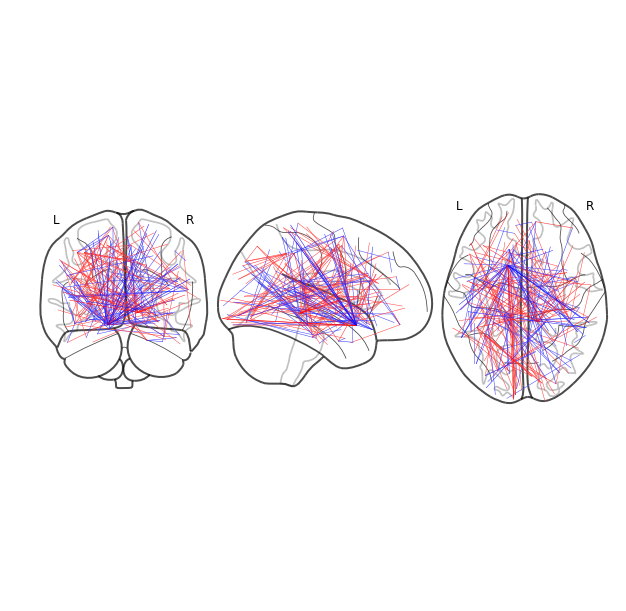

In [9]:
# use nilearn's plot_connectome function to visualize the weights
weight_mtx=mtx_from_utr(weights)
fig=plt.figure(figsize=(10,10))
nilearn.plotting.plot_connectome(weight_mtx, parceldata.iloc[:,2:5],
                                edge_threshold='99.9%',
                                node_size=0,
                                edge_kwargs={'linewidth':0.5},
                                figure=fig)


As you can see, it's somewhat difficult to discern much by looking at the connections projected using orthogonal sections. Another alternative is to use the known network structure in the data, and summarize the weights in terms of within- and between-network connectivity. To do this, we create a function that takes in a set of weights and summarizes them across all combinations of networks.



In [12]:
def parcelmap(weights,parceldata,show_image=True):
    """
    summarize weights by network and plot results
    """
    parcel_networks=parceldata.iloc[:,7].values
    networks=numpy.unique(parcel_networks)
    n_networks=len(networks)
    # create a matrix that defines the networks
    colnetworkmtx=numpy.tile(parcel_networks,(630,1))
    colnetworkmtx[numpy.diag_indices_from(colnetworkmtx)]='none'
    rownetworkmtx=colnetworkmtx.T
    
    # loop through for each run, so that we can compute stats on combined weights
    network_mtx=numpy.zeros((n_networks,n_networks))
   
    weight_mtx=mtx_from_utr(weights)

    # summarize weights by networks
    for i in range(n_networks):
        for j in range(n_networks):
            match=numpy.where((rownetworkmtx==networks[i]) * (colnetworkmtx==networks[j]))
            matchmtx=weight_mtx[match]
            network_mtx[i,j]=numpy.mean(matchmtx)
    if show_image:
        plt.figure(figsize=(8,8))
        plt.imshow(network_mtx,cmap='plasma')
        plt.colorbar()
        ax=plt.gca()
        ax.set_yticks(numpy.arange(0,14))
        ax.set_yticklabels(networks)
        plt.xticks(numpy.arange(0,14), rotation='vertical')
        ax.set_xticklabels(networks)

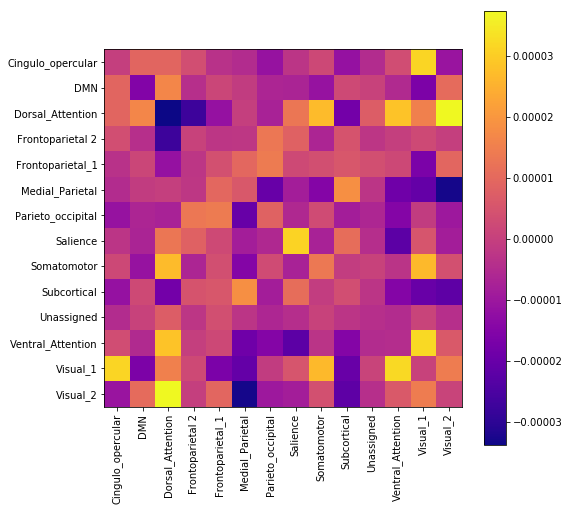

In [13]:
parcelmap(weights,parceldata)

From this we can see that it's the visual and somatomotor networks and their interconnections that are positively predictive of fatigue, and dorsal attention, frontoparietal, and medial parietal networks that are negatively predictive with fatigue.